In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#Import Data
local_path = r'C:\Users\alons\OneDrive\Documentos\GitHub\Tarea-NSP\\'
datos = pd.read_csv(local_path + 'data_new_features_clean.csv')


In [3]:
#Transform Data into Numerical:

datos['FechaNac'] = pd.to_datetime(datos['FechaNac'])
datos['FechaReserva'] = pd.to_datetime(datos['FechaReserva'])
datos['FechaCita'] = pd.to_datetime(datos['FechaCita'])
datos = datos.sort_values('FechaCita')

In [4]:
datos.dtypes

Unnamed: 0                           int64
PAID                               float64
FechaNac                    datetime64[ns]
Sexo                                object
Comuna                              object
Provincia                           object
Region                              object
Agenda                              object
TipoProfesional                     object
Especialidad                        object
TipoAtencion                        object
CodPrestacion                      float64
Prestacion                          object
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
EstadoCita                          object
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atencion

In [5]:
#Transform Data into Numerical
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


column_list = [] #str columns
for column in datos.columns:
    if datos[column].dtype == 'O':
        column_list.append(column)

datos_num = datos[column_list].astype(str).apply(le.fit_transform)
for column in datos.columns:
    if datos[column].dtype != 'O':
        datos_num[column] = datos[column]

In [6]:
datos_num.dtypes

Sexo                                 int32
Comuna                               int32
Provincia                            int32
Region                               int32
Agenda                               int32
TipoProfesional                      int32
Especialidad                         int32
TipoAtencion                         int32
Prestacion                           int32
EstadoCita                           int32
Unnamed: 0                           int64
PAID                               float64
FechaNac                    datetime64[ns]
CodPrestacion                      float64
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atencion

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(random_state=0,criterion='entropy')
clf1.fit(datos_num[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], datos_num['EstadoCita'])

clf1.score(datos_num[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion']], datos_num['EstadoCita'])

0.6331829818359137

In [8]:
clf1.feature_importances_

array([0.08720947, 0.29657488, 0.10865181, 0.05620149, 0.21089883,
       0.1207199 , 0.03508568, 0.07695467, 0.00770328])

In [9]:
clf2 = DecisionTreeClassifier(random_state=0,criterion='entropy')
clf2.fit(datos_num[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda',
                   'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                   'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                   'Distancia', 'Dia Cita']], datos_num['EstadoCita'])

clf2.score(datos_num[['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 
                     'TipoProfesional','Especialidad', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita']], datos_num['EstadoCita'])

0.9944004226096144

In [10]:
clf2.feature_importances_

array([0.03585399, 0.11406871, 0.01862144, 0.01020212, 0.02815612,
       0.01025302, 0.00408738, 0.01346436, 0.00462828, 0.33840563,
       0.19048596, 0.05534581, 0.03901903, 0.0475979 , 0.02694909,
       0.00765879, 0.05520238])

C:\Users\alons\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\alons\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\alons\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\alons\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


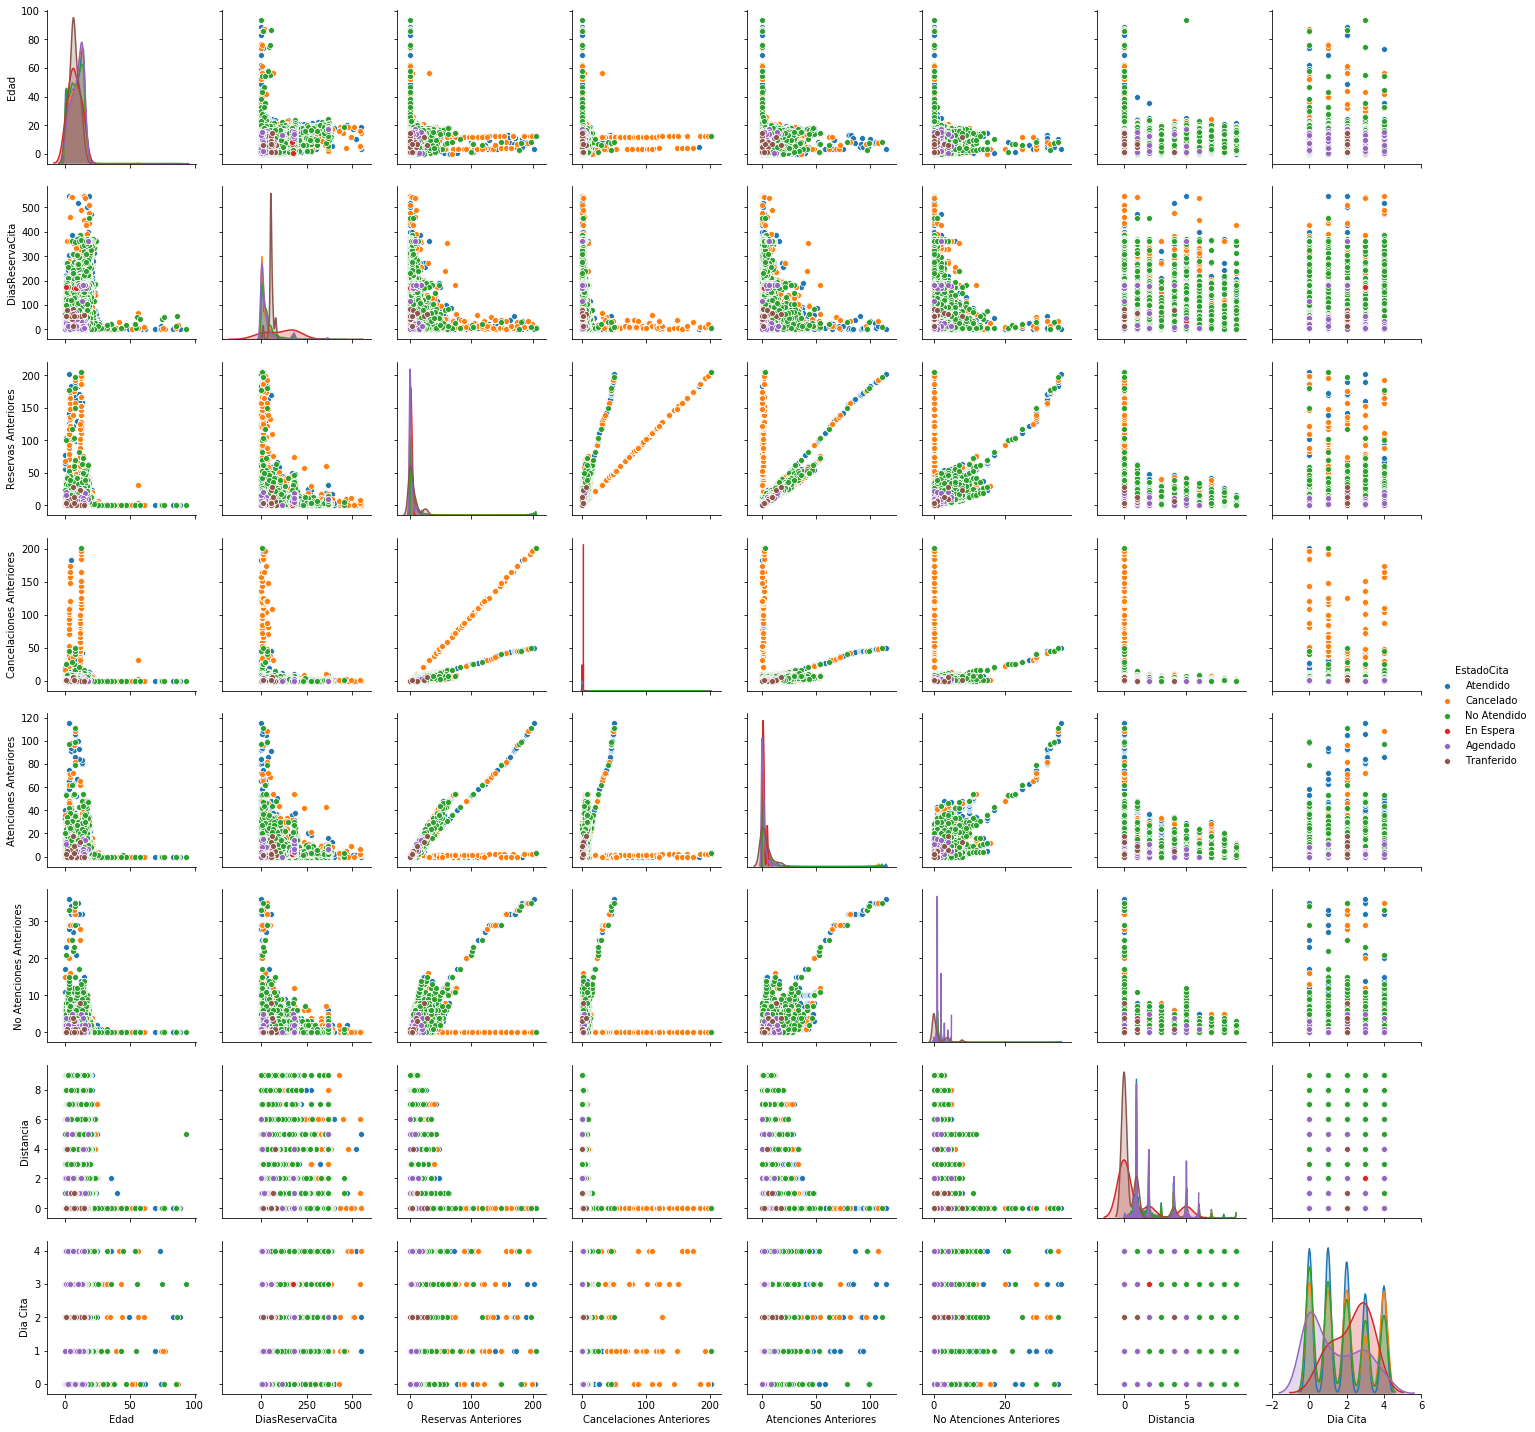

In [11]:
sns.pairplot(datos[['Sexo', 'TipoAtencion', 'Prestacion','Edad',
                     'DiasReservaCita','Reservas Anteriores','Cancelaciones Anteriores','Atenciones Anteriores','No Atenciones Anteriores',
                    'Distancia','Dia Cita','EstadoCita']], hue='EstadoCita')

## Parte 4 SVM

Recordando lo visto en clase, el problema SVM consiste en la separación de un conjunto de observaciones $x_{i} \in \mathbb{R}^{m}$, $i \in \{1,..,n\}$, en este caso de la base de datos ya especificada, donde $n = 122.862$ es la cantidad de observaciones y $m = 13$ es la cantidad de variables a tener en cuenta para el análisis, por su etiqueda correspondiente $y_{i} \in \{'Atendido', 'No Atendido', 'Cancelado'\}$ mediante hiperplanos. 

La siguiente formulación corresponde al caso en que el etiquetado es binario, y existen variables de holgura $\xi_{i}$ que permiten darle factibilidad al problema incluso si los datos no son separables, además de la función $\phi(.)$, que representa una función Kernel. La constante $C \ge 0$ corresponde a la penalización asociada a las holguras, que variaría según se estime conveniente. 

%%latex


\begin{equation*}
\begin{aligned}
& \underset{w,b,\xi}{\text{minimize}}
& & \frac{1}{2}w^{T}w + C\sum_{i = 1}^{n}\xi_{i} \\
& \text{subject to}
& & y_{i}(w^{T}\phi(x_{i})+b) \geq 1-\xi_{i} , \; i = 1, \ldots, n.\\
& & & \xi_{i} \geq 0
\end{aligned}
\end{equation*}

El modelo anterior es el que utiliza la librería LIBSVM para el método SVC, que se utilizará para realizar el estudio de la pertinencia de este modelo para el problema NSP. Cabe destacar que es un modelo generalizado para $n$ etiquetas, que en este caso son $\{'Atendido', 'No Atendido', 'Cancelado'\}$, identificadas con los números $\{1,2,4\}$ respectivamente. ESsto para poder correr el modelo.

Dado que se desea trabajar sólo con esas tres etiquetas, se procederá a eliminar aquellas distintas de estas.

In [12]:
datos_num_three_states = datos_num[(datos_num.EstadoCita != 0) & (datos_num.EstadoCita != 3)
                                                 & (datos_num.EstadoCita != 5)]

Como se mencionó anteriormente, esta es una base de datos desbalanceada respecto a la muestra de etiquetas, como se puede ver en el siguiente gráfico. Los porcentajes de cada cual son los siguientes:

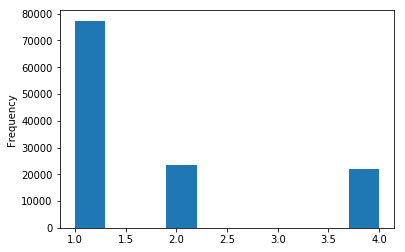

In [13]:
datos_num_three_states['EstadoCita'].plot.hist()

In [14]:
frecuency = datos_num_three_states.groupby('EstadoCita').count()
print(100*frecuency.iloc[0,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'Atendido'")
print(100*frecuency.iloc[1,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'Cancelado'")
print(100*frecuency.iloc[2,1]/(frecuency.iloc[0,1]+frecuency.iloc[1,1]+frecuency.iloc[2,1]), "porcentaje de 'No Atendido'")

62.988556266380165 porcentaje de 'Atendido'
19.012387882339535 porcentaje de 'Cancelado'
17.9990558512803 porcentaje de 'No Atendido'


In [15]:
datos.groupby('EstadoCita').count()

,Unnamed: 0,PAID,FechaNac,Sexo,Comuna,Provincia,Region,Agenda,TipoProfesional,Especialidad,...,FechaReserva,FechaCita,Edad,DiasReservaCita,Dia Cita,Distancia,Reservas Anteriores,Cancelaciones Anteriores,Atenciones Anteriores,No Atenciones Anteriores
EstadoCita,,,,,,,,,,,,,,,,,,,,,
Agendado,157,157,157,157,157,157,157,157,157,157,...,157,157,157,157,157,157,157,157,157,157
Atendido,77389,77389,77389,77389,77389,77389,77389,77389,77389,77389,...,77389,77389,77389,77389,77389,77389,77389,77389,77389,77389
Cancelado,23359,23359,23359,23359,23359,23359,23359,23359,23359,23359,...,23359,23359,23359,23359,23359,23359,23359,23359,23359,23359
En Espera,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
No Atendido,22114,22114,22114,22114,22114,22114,22114,22114,22114,22114,...,22114,22114,22114,22114,22114,22114,22114,22114,22114,22114
Tranferido,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19


A continuación, se procede a realizar un 'Undersampling' de la etiqueta $'Atendido'$ con un 20% seleccionado aleatoreamente, mientras que se toman un 50% de las restantes de  la misma forma. Esto para generar un conjunto de entrenamiento adecuado para el clasificador de SVM, debido que, dadas pruebas anteriores, al entrenar con una gran cantidad de elementos $'Atendidos'$ se llegaba a que no se reconocían los otros dos tipos etiquetar, i.e., todo quedaba etiquetado con $'Atendido'$. Esto da como resultado un DataFrame de tamaño $n_{training}=38.215$ y  $ m = 13$. Como consecuencia directa, el conjunto de datos test queda de tamaño $n_{test} = 82.647$ con las mismas $m$ variables.

In [16]:
datos_num_atendidos = datos_num[datos_num.EstadoCita == 1]
datos_num_cancelados = datos_num[datos_num.EstadoCita == 2]
datos_num_no_asistidos = datos_num[datos_num.EstadoCita == 4]

In [17]:
print("\n",datos_num_atendidos.shape, "\n",datos_num_cancelados.shape, "\n",datos_num_no_asistidos.shape)


 (77389, 24) 
 (23359, 24) 
 (22114, 24)


In [18]:
datos_num_atendidos_training = datos_num_atendidos.sample(frac=0.20, random_state=857)
datos_num_cancelados_training = datos_num_cancelados.sample(frac=0.5, random_state=857)
datos_num_no_asistidos_training = datos_num_no_asistidos.sample(frac=0.5, random_state=857)

In [19]:
datos_num_training = datos_num_atendidos_training.append(datos_num_cancelados_training,sort=False)
datos_num_training = datos_num_training.append(datos_num_no_asistidos_training,sort=False)

In [20]:
print(datos_num_training.columns)
datos_num_training.dtypes

Index(['Sexo', 'Comuna', 'Provincia', 'Region', 'Agenda', 'TipoProfesional',
       'Especialidad', 'TipoAtencion', 'Prestacion', 'EstadoCita',
       'Unnamed: 0', 'PAID', 'FechaNac', 'CodPrestacion', 'FechaReserva',
       'FechaCita', 'Edad', 'DiasReservaCita', 'Dia Cita', 'Distancia',
       'Reservas Anteriores', 'Cancelaciones Anteriores',
       'Atenciones Anteriores', 'No Atenciones Anteriores'],
      dtype='object')


Sexo                                 int32
Comuna                               int32
Provincia                            int32
Region                               int32
Agenda                               int32
TipoProfesional                      int32
Especialidad                         int32
TipoAtencion                         int32
Prestacion                           int32
EstadoCita                           int32
Unnamed: 0                           int64
PAID                               float64
FechaNac                    datetime64[ns]
CodPrestacion                      float64
FechaReserva                datetime64[ns]
FechaCita                   datetime64[ns]
Edad                               float64
DiasReservaCita                      int64
Dia Cita                             int64
Distancia                            int64
Reservas Anteriores                  int64
Cancelaciones Anteriores             int64
Atenciones Anteriores                int64
No Atencion

In [21]:
y = datos_num_training['EstadoCita']
X = datos_num_training.drop(['EstadoCita','FechaNac','FechaReserva','FechaCita','Unnamed: 0','PAID',
                             'Prestacion','Provincia','Region','CodPrestacion','No Atenciones Anteriores'], axis=1)

In [22]:
datos_num_atendidos_training.shape
X

,Sexo,Comuna,Agenda,TipoProfesional,Especialidad,TipoAtencion,Edad,DiasReservaCita,Dia Cita,Distancia,Reservas Anteriores,Cancelaciones Anteriores,Atenciones Anteriores
64202,1,129,1,1,0,1,3.484932,38,4,0,1,0,1
69810,3,172,4,2,1,1,2.928767,3,4,0,0,0,0
100759,3,150,3,2,1,2,8.358904,1,2,7,9,1,8
87829,3,185,0,2,1,2,14.920548,126,1,0,2,0,2
79915,3,261,3,2,1,2,12.641096,0,1,2,8,0,7
11834,1,272,4,2,1,2,13.679452,0,4,0,1,0,1
12375,1,240,1,2,0,1,1.457534,29,4,1,0,0,0
40140,1,130,2,3,0,3,2.254795,37,3,0,0,0,0
79365,3,272,3,2,1,1,2.326027,0,1,0,1,1,0
25855,1,172,1,2,0,1,0.441096,79,3,0,0,0,0


In [23]:
training_index = list(X.index)

In [24]:
datos_num_test = datos_num_three_states.drop(training_index)
datos_num_test_unlabeled = datos_num_test.drop(['EstadoCita','FechaNac','FechaReserva','FechaCita','Unnamed: 0','PAID',
                                                 'Prestacion','Provincia','Region','CodPrestacion'
                                                ,'No Atenciones Anteriores'], axis=1)
datos_num_test_labels = datos_num_test['EstadoCita']
datos_num_test_unlabeled.shape


(84647, 13)

In [25]:
##strict SVM 
import time
start1 = time.time()
from sklearn.svm import SVC
clf = SVC(C = 1 , gamma='auto')
clf.fit(X, y)
end1 = time.time()

In [31]:
start2 = time.time()
print(clf.score(datos_num_test_unlabeled, datos_num_test_labels))
end2 = time.time()
print("el timepo de ejecución fue de", (start1+start2-end1-end2)/60 , " segundos.")

0.5742908785899087
el timepo de ejecución fue de -7.582670426368713  segundos.


In [28]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (7,5), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

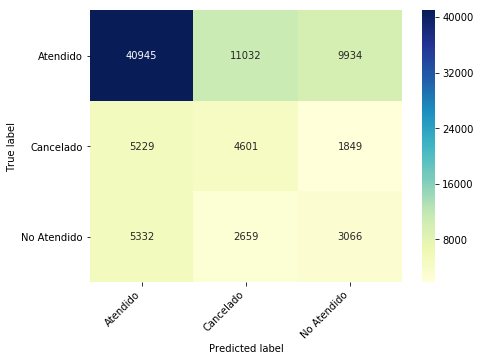

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(datos_num_test_unlabeled)
class_numbers = datos_num_test_labels.unique()
class_numbers.sort()
class_names = le.inverse_transform(class_numbers)
cm = confusion_matrix(datos_num_test_labels,y_pred)
cm_fig = print_confusion_matrix(cm,class_names)

In [30]:
##Standardization training set
training_values = datos_num_test_unlabeled.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
training_normalized = min_max_scaler.fit_transform(training_values)
df_training_normalized = pd.DataFrame(training_normalized)
df_training_normalized.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.333333,1.000000,0.2,0.666667,0.0,0.333333,0.080523,0.025641,1.0,0.0,0.0,0.0,0.0
1,1.000000,0.632353,0.2,0.666667,0.0,0.333333,0.005817,0.078755,1.0,0.0,0.0,0.0,0.0
2,0.333333,0.477941,0.2,0.666667,0.0,0.333333,0.069859,0.078755,1.0,0.0,0.0,0.0,0.0
3,0.333333,0.632353,0.6,0.666667,1.0,0.000000,0.040570,0.056777,1.0,0.0,0.0,0.0,0.0
4,0.333333,0.632353,0.2,0.666667,0.0,0.666667,0.063984,0.020147,1.0,0.0,0.0,0.0,0.0


In [ ]:
##Standardization test set
